In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

from src.utils import *
from src.impedance import *
from src.datatype import MRIDataset, iUSDataset
from src.renderer import *
from src.cone import *
from src.impedance import ImpedanceEstimator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.cluster import KMeans
import cv2

In [3]:
patient_id = "003" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"

# Load with nibabel; each img is a Nifti1Image object
us_img = nib.load(str(image_path / iUS_file))
t1_img = nib.load(str(image_path / t1_file))
t2_img = nib.load(str(image_path / t2_file))

# Extract data arrays (as NumPy) and affines
US_vol = us_img.get_fdata(dtype=np.float32)
US_affine = us_img.affine
T1_vol = t1_img.get_fdata(dtype=np.float32)
T1_affine = t1_img.affine
T2_vol = t2_img.get_fdata(dtype=np.float32)
T2_affine = t2_img.affine

# Preliminary computations

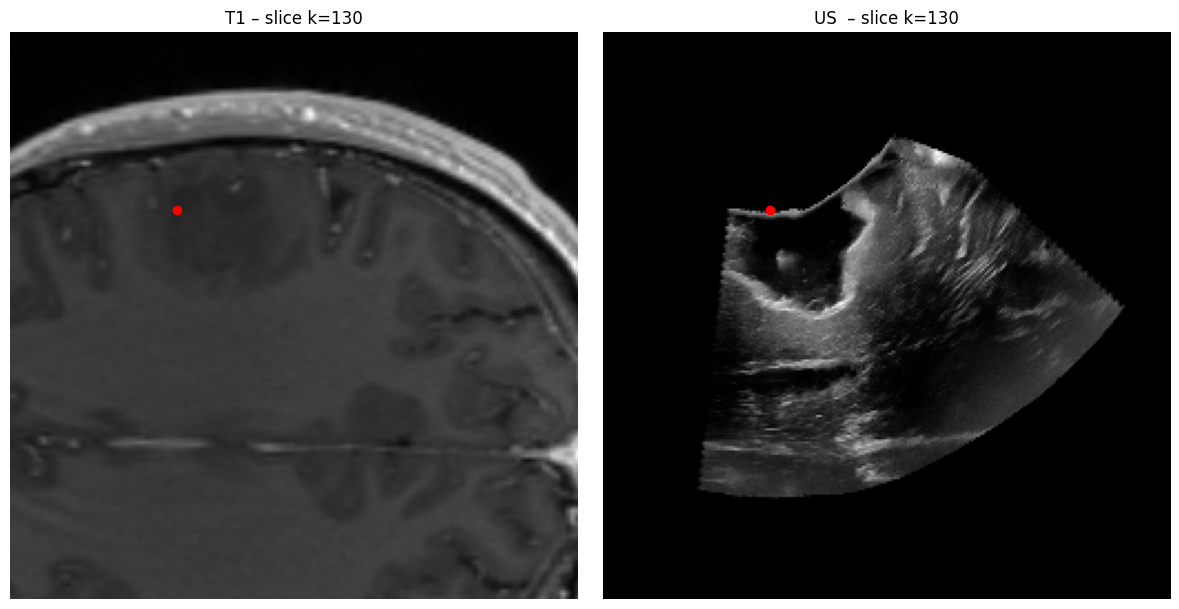

In [168]:
i_mri, j_mri, slice_idx = 175, 75, 130 # Example indices for T1 MRI
us_slice, us_idx = mri_to_us_point(i_mri, j_mri, slice_idx, T1_vol, T1_affine, US_vol, US_affine)
plot_mri_us_aligned(i_mri, j_mri, slice_idx, T1_vol, us_slice, us_idx)

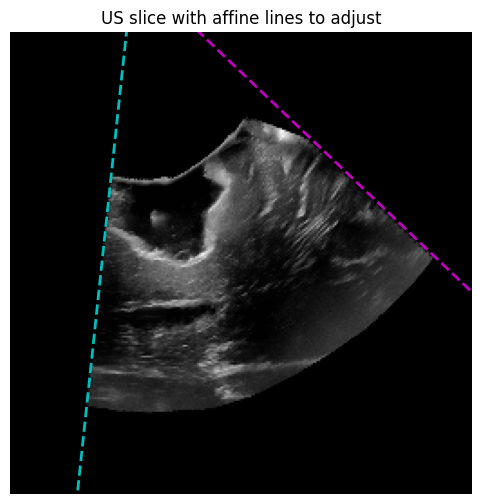

In [169]:
# US edges parameters
mL, bL = 9.4, -350  # Left edge line parameters (slope, intercept)
mR, bR = -0.9524, 355  # Right edge line parameters (slope, intercept)
# mL, bL = -0.1, 216
# mR, bR = 1.05, -117
plot_us_with_affine_lines(us_slice, mL, bL, mR, bR)

_, _, k_us = us_idx
H_us, W_us = us_slice.shape

In [170]:
cone_params = compute_us_apex_and_direction(mL, bL, mR, bR)
x0, y0 = cone_params["apex"]
print("Source :", (x0, y0))
opening_angle   = cone_params["opening_angle"]
direction_vec   = cone_params["direction_vector"]

Source : (68.10015068969514, 290.1414164831343)


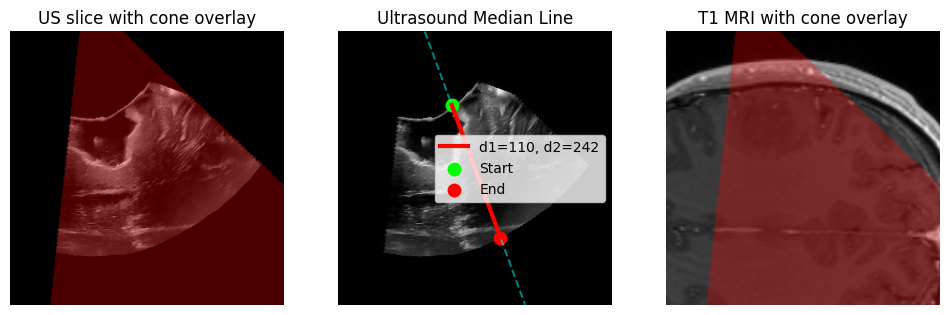

In [171]:
mask_us = overlay_cone(us_slice, apex=np.array([x0, y0]), direction_vector=direction_vec, opening_angle=opening_angle)
fig, ax = plt.subplots(1,3, figsize=(12, 6))
plot_overlay_cone(us_slice, mask_us, ax=ax[0])
plot_median_line(us_slice, cone_params["apex"], cone_params["direction_vector"], d1=110, d2=242, ax=ax[1])

t1_slice = T1_vol[:, :, slice_idx]
H_t1, W_t1 = t1_slice.shape
apex_us_vox = np.array([x0, y0, k_us])

apex_mri_world, direction_mri_world = cone_us_to_mri_world(apex_us_vox, direction_vec, US_affine, T1_affine)

# Visualize result
mask_mri = overlay_cone(t1_slice, apex=apex_mri_world[:2], direction_vector=direction_mri_world, opening_angle=opening_angle)
plot_overlay_cone(t1_slice, mask_mri, ax=ax[2], title="T1 MRI with cone overlay")

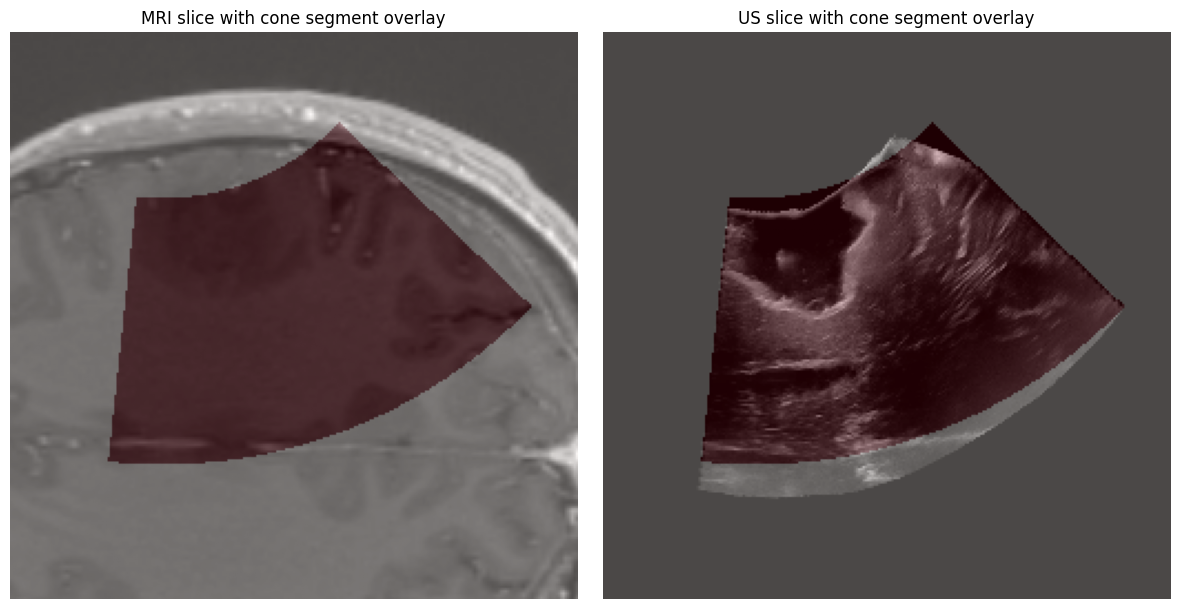

In [186]:
import numpy as np

def depr_mask_cone_segment(mask, apex, direction, d1, d2):
    """
    Keep only the part of the cone between distances d1 and d2 from the apex along the median direction.
    mask: 2D boolean array (the cone mask)
    apex: (x0, y0) coordinates (float)
    direction: (dx, dy) unit vector (float)
    d1, d2: distances from apex (float)
    Returns: new mask (bool)
    """
    H, W = mask.shape
    x0, y0 = apex
    dx, dy = direction / np.linalg.norm(direction)
    # Create coordinate grid
    xx, yy = np.meshgrid(np.arange(W), np.arange(H))
    # Vector from apex to each point
    vx = xx - x0
    vy = yy - y0
    # Project each point onto the median direction
    proj = vx * dx + vy * dy
    # Keep only points between d1 and d2
    segment_mask = (proj >= d1) & (proj <= d2)
    return mask & segment_mask

#rounded version
def mask_cone_segment(mask, apex, direction, d1, d2):
    """
    Keep only the part of the cone between distances d1 and d2 from the apex along the median direction,
    with rounded caps at d1 and d2.
    
    Parameters:
        mask: 2D boolean array (the cone mask)
        apex: (x0, y0) coordinates (float)
        direction: (dx, dy) unit vector (float)
        d1, d2: distances from apex (float)
        
    Returns:
        mask_segment: 2D boolean array with rounded cone segment
    """
    H, W = mask.shape
    x0, y0 = apex
    dx, dy = direction / np.linalg.norm(direction)
    # Coordinate grid
    xx, yy = np.meshgrid(np.arange(W), np.arange(H))
    # Vector from apex to each point
    vx = xx - x0
    vy = yy - y0
    # Project each point onto the median direction (how far along the cone axis)
    proj = vx * dx + vy * dy

    # Project each point onto the median direction
    proj = vx * dx + vy * dy

    # Calculate distance from apex to each point
    dist = np.sqrt(vx**2 + vy**2)
    # Create a mask for points within the rounded caps

    rounded_mask_d1 = dist >= d1
    rounded_mask_d2 = dist <= d2
    # Combine the masks
    mask = mask & (rounded_mask_d1 | rounded_mask_d2)
    return mask & rounded_mask_d1 & rounded_mask_d2


apex = apex_mri_world[:2]
direction = direction_mri_world[:2]
d1, d2 = 110, 230

mask_segment_mri = mask_cone_segment(mask_mri, apex, direction, d1, d2)
mask_segment_us = mask_cone_segment(mask_us, np.array([x0, y0]), direction_vec, d1, d2)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(t1_slice, cmap='gray', origin='lower')
axs[0].imshow(mask_segment_mri, cmap='Reds', alpha=0.3, origin='lower')
axs[0].set_title("MRI slice with cone segment overlay")
axs[0].axis('off')

axs[1].imshow(us_slice, cmap='gray', origin='lower')
axs[1].imshow(mask_segment_us, cmap='Reds', alpha=0.3, origin='lower')
axs[1].set_title("US slice with cone segment overlay")
axs[1].axis('off')

plt.tight_layout()
plt.show()


[INFO] Tracing rays with source: tensor([ 68.1002, 290.1414, 130.0000], dtype=torch.float64) and directions shape: torch.Size([64, 1, 3])
[INFO] Starting from sample index: 110 (for instance, to skip bones)
[INFO] Padded output to start from sample index: 110 torch.Size([64, 251])


C:\Users\noe\AppData\Local\Temp\ipykernel_3396\3149360578.py:16: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\noe\AppData\Local\Temp\ipykernel_3396\3149360578.py:17: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\noe\AppData\Local\Temp\ipykernel_3396\3149360578.py:18: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Text(0.5, 1.0, 'Rendered Ultrasound Image')

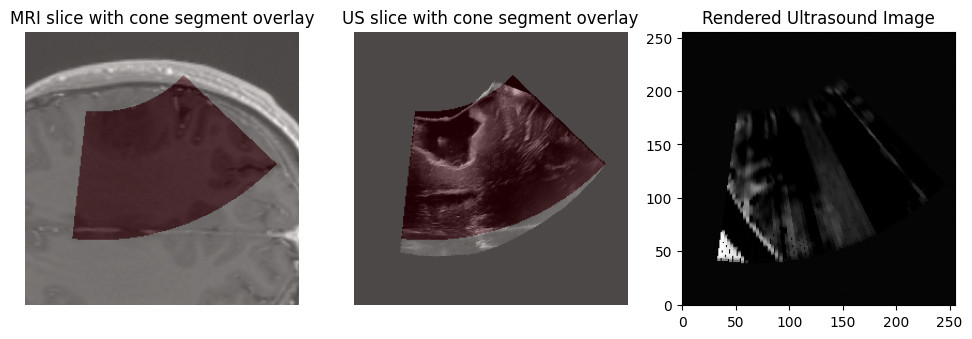

In [191]:
# Let's check the RENDERER
UR = UltrasoundRenderer(250, 0.0001)
x,z,intensities = UR.plot_beam_frame(
    torch.tensor(T1_vol),
    source=source,
    directions=directions,
    angle=np.degrees(opening_angle)/2,
    start=d1,
    plot=False
)

x_rot, z_rot = rotate_around_apex(x, 
                                  z, 
                                  apex=apex_mri_world[:2],
                                  median=[-0.3,-0.9])
final_image = differentiable_splat(torch.tensor(x_rot), 
                                   torch.tensor(z_rot), 
                                   torch.tensor(intensities), H=256, W=256, sigma=0.5)

fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].imshow(t1_slice, cmap='gray', origin='lower')
axs[0].imshow(mask_segment_mri, cmap='Reds', alpha=0.3, origin='lower')
axs[0].set_title("MRI slice with cone segment overlay")
axs[0].axis('off')

axs[1].imshow(us_slice, cmap='gray', origin='lower')
axs[1].imshow(mask_segment_us, cmap='Reds', alpha=0.3, origin='lower')
axs[1].set_title("US slice with cone segment overlay")
axs[1].axis('off')

axs[2].imshow(final_image, cmap='gray', origin='lower', vmin=-0.002)
axs[2].set_title("Sampeld Ultrasound Image")

plt.title("Rendered Ultrasound Image")




Looks like there is some issue here...

# Train MLP to find Z_vol (Acoustic Impedance)

In [9]:
class ImpedanceLearner(nn.Module):
    """Learning the mapping MRI -> Acoustic Impedance"""
    def __init__(self, input_dim=1, hidden_dims=[32, 32]):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], 1)
        )
    
    def forward(self, x):
        return self.mlp(x)

class UltrasoundSynthesisModel:
    def __init__(self, 
                 renderer:UltrasoundRenderer, 
                 impedance_model:ImpedanceLearner, 
                 us_real, 
                 mask, 
                 source:torch.Tensor, 
                 directions:torch.Tensor, 
                 angle:float):
        """
        renderer: UltrasoundRenderer
        impedance_model: ImpedanceLearner
        us_real: Real ultrasound tensor (n_rays, depth)
        mask: (n_rays, depth)
        source: (3,)
        directions: (n_rays, 3)
        angle: float, angle of the ultrasound beam in radians
        """
        self.renderer = renderer
        self.model = impedance_model
        self.us_real = us_real
        self.mask = mask
        self.source = source
        self.directions = directions
        self.angle = angle
        
        self.real_min = us_real.min()
        self.real_max = us_real.max()
        self.us_real_norm = (us_real - self.real_min) / (self.real_max - self.real_min + 1e-8)
        
    def compute_impedance_volume(self, t1_volume):
        """Converts T1-weighted MRI volume to acoustic impedance volume"""
        mean = t1_volume.mean()
        std = t1_volume.std()
        vol_norm = (t1_volume - mean) / (std + 1e-8)
        shape = vol_norm.shape
        vol_flat = vol_norm.reshape(-1, 1)
        with torch.no_grad():
            Z_pred = self.model(vol_flat).squeeze()
        Z_vol = torch.full_like(vol_norm, 400.0)
        Z_vol = Z_pred.reshape(shape) * 1e6
        return Z_vol

    def generate_synthetic_us(self, Z_vol):
        """Generate synthetic ultrasound from impedance volume"""
        x, z, intensities = self.renderer.plot_beam_frame(
            volume=Z_vol,
            source=self.source,
            directions=self.directions,
            angle=self.angle,
            plot=False,
            artifacts=True,
            start=0.4
        )
        synth_us = rasterize_fan(x, z, intensities)
        return synth_us

    def gradient_loss(self, a, b, mask):
        """Loss robust to edge artifacts"""
        a_grad = torch.abs(a[:, 1:] - a[:, :-1])
        b_grad = torch.abs(b[:, 1:] - b[:, :-1])
        return F.l1_loss(a_grad[mask[:, 1:]], b_grad[mask[:, 1:]])

    def train_step(self, t1_volume, optimizer):
        optimizer.zero_grad()
        
        # Forward pass
        Z_vol = self.compute_impedance_volume(t1_volume)
        synth_us = self.generate_synthetic_us(Z_vol)
        
        # Normalisation
        synth_norm = (synth_us - synth_us.min()) / (synth_us.max() - synth_us.min() + 1e-8)
        
        # Calcul des pertes
        main_loss = F.mse_loss(synth_norm[self.mask], self.us_real_norm[self.mask])
        edge_loss = self.gradient_loss(synth_norm, self.us_real_norm, self.mask)
        total_loss = main_loss + 0.5 * edge_loss
        
        # Backpropagation
        total_loss.backward()
        optimizer.step()
        
        return total_loss.item()

def generate_cone_directions(direction_mri_world, opening_angle, n_rays):
    """
    Generate a fan of directions centered on direction_mri_world,
    spanning opening_angle (in radians), in the (x, y) plane (z=0).
    Returns: (n_rays, 3) tensor
    """
    # Normalize the median direction
    d = np.array(direction_mri_world[:2])
    d = d / np.linalg.norm(d)
    # Orthogonal vector in-plane
    ortho = np.array([-d[1], d[0]])
    # Angles from -half to +half opening
    angles = np.linspace(-opening_angle/2, opening_angle/2, n_rays)
    directions = []
    for a in angles:
        v = np.cos(a) * d + np.sin(a) * ortho
        directions.append([v[0], v[1], 0.0])
    return torch.tensor(directions, dtype=torch.float32)

In [10]:
renderer = UltrasoundRenderer(num_samples=220, attenuation_coeff=0.0001)
impedance_model = ImpedanceLearner()

n_rays = 64
source = torch.tensor(apex_mri_world)
directions = generate_cone_directions(direction_mri_world, opening_angle, n_rays)

us_real = us_slice
cone_mask = mask_segment_us

trainer = UltrasoundSynthesisModel(
    renderer,
    impedance_model,
    us_real,
    cone_mask,
    source,
    directions,
    angle=np.degrees(opening_angle)/2
)

optimizer = torch.optim.Adam(impedance_model.parameters(), lr=1e-4)

for epoch in range(1000):
    loss = trainer.train_step(torch.tensor(T1_vol, dtype=torch.float32), optimizer)
    print(f"Epoch {epoch}, Loss: {loss:.6f}")

# torch.save(impedance_model.state_dict(), "impedance_model.pth")

[INFO] Starting from sample index: 88 (for instance, to skip bones)
[INFO] Padded output to start from sample index: 88 (64, 221)


IndexError: boolean index did not match indexed array along axis 0; size of axis is 8512 but size of corresponding boolean axis is 256

In [11]:
T1_volume = torch.tensor(T1_vol, dtype=torch.float32)

T1_data = pd.DataFrame(
    {"organ": ["fat","liver","muscle","BWM","BGM","CSF","AIR"],
     "intensity": [260,500,870,780,920,2500, 0], 
     "impedance": [1.34e6,1.67e6,1.68e6,1.6e6,1.6e6,1.5e6, 0.0004e6]}
)

t1 = T1_data['intensity'].values.reshape(-1,1)
z1 = T1_data['impedance'].values.reshape(-1,1)

t1 = np.array([-2.0, -1.0, 0.0,  1.5]).reshape(-1,1)
z1 = np.array([400,  1.52e6, 1.7e6, 1.38e6]).reshape(-1,1)

X1 = torch.tensor(t1, dtype=torch.float32)
Y1 = torch.tensor(z1, dtype=torch.float32)

model_t1 = ImpedanceEstimator.train_model(X1, Y1, input_dim=1)
Z_vol = ImpedanceEstimator.compute_impedance_volume(T1_volume, model_t1, threshold=50)

[INFO] Starting from sample index: 110 (for instance, to skip bones)
[INFO] Padded output to start from sample index: 110 (64, 221)
Intensity range: 0.0000 to 0.0612
tensor([ 68.1002, 290.1414, 130.0000], dtype=torch.float64) tensor([[-0.1058, -0.9944,  0.0000],
        [-0.0913, -0.9958,  0.0000],
        [-0.0768, -0.9970,  0.0000],
        [-0.0623, -0.9981,  0.0000],
        [-0.0478, -0.9989,  0.0000],
        [-0.0333, -0.9994,  0.0000],
        [-0.0188, -0.9998,  0.0000],
        [-0.0042, -1.0000,  0.0000],
        [ 0.0103, -0.9999,  0.0000],
        [ 0.0248, -0.9997,  0.0000],
        [ 0.0394, -0.9992,  0.0000],
        [ 0.0539, -0.9985,  0.0000],
        [ 0.0684, -0.9977,  0.0000],
        [ 0.0829, -0.9966,  0.0000],
        [ 0.0974, -0.9952,  0.0000],
        [ 0.1118, -0.9937,  0.0000],
        [ 0.1263, -0.9920,  0.0000],
        [ 0.1407, -0.9901,  0.0000],
        [ 0.1550, -0.9879,  0.0000],
        [ 0.1694, -0.9856,  0.0000],
        [ 0.1837, -0.9830,  0.0000

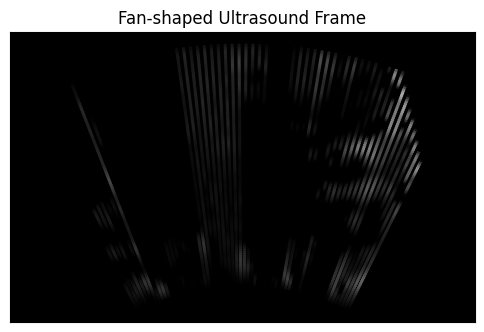

In [36]:
renderer = UltrasoundRenderer(num_samples=220, attenuation_coeff=0.0001)

# Paramètres géométriques
n_rays = 64
source = torch.tensor(apex_mri_world)

def generate_cone_directions(direction_mri_world, opening_angle, n_rays):
    """
    Generate a fan of directions centered on direction_mri_world,
    spanning opening_angle (in radians), in the (x, y) plane (z=0).
    Returns: (n_rays, 3) tensor
    """
    # Normalize the median direction
    d = np.array(direction_mri_world[:2])
    d = d / np.linalg.norm(d)
    # Orthogonal vector in-plane
    ortho = np.array([-d[1], d[0]])
    # Angles from -half to +half opening
    angles = np.linspace(-opening_angle/2, opening_angle/2, n_rays)
    directions = []
    for a in angles:
        v = np.cos(a) * d + np.sin(a) * ortho
        directions.append([v[0], v[1], 0.0])
    return torch.tensor(directions, dtype=torch.float32)

directions = generate_cone_directions(direction_mri_world, opening_angle, n_rays)
Z_vol_base = model_one.forward(torch.tensor(T1_vol))
synth_us, _ = renderer.plot_beam_frame(
            volume=Z_vol_base.detach(),
            source=source,
            directions=directions,
            angle=np.degrees(opening_angle)/2,
            plot=True,
            artifacts=False,
            start=d1
        )
print(source, directions, np.degrees(opening_angle))

Text(0.5, 1.0, 'Synthetic directions')

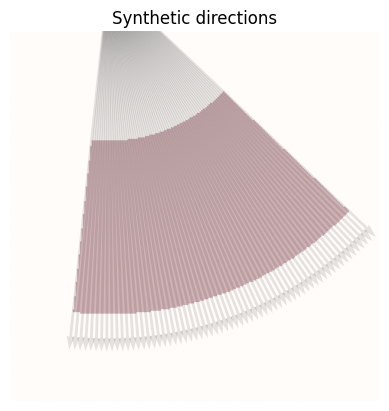

In [23]:
# confirm directions
plt.quiver(
    apex_mri_world[0].repeat(64).reshape(-1,1), 
    apex_mri_world[1].repeat(64).reshape(-1,1),
    directions[:, 0].numpy(), directions[:, 1].numpy(),
    scale=1,
    alpha=0.1  
)
plt.xlim(0, 256)
plt.ylim(0, 256)
plt.imshow(mask_segment_mri, cmap='Reds', alpha=0.3)
plt.axis('off')
plt.title("Synthetic directions")

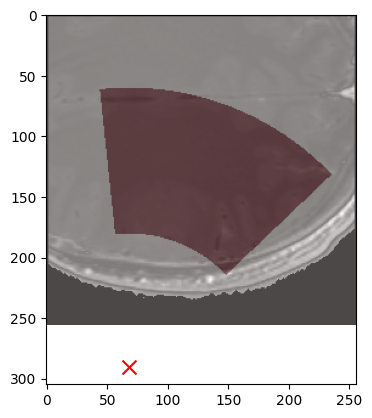

In [27]:
plt.imshow(Z_vol[:, :, 130], cmap='gray')
plt.imshow(mask_segment_mri, cmap='Reds', alpha=0.3)
plt.scatter(
    apex_mri_world[0], 
    apex_mri_world[1], 
    c='red', s=100, label='Apex', marker='x'
)


# REMASTERED 2

In [ ]:
class ImpedanceLearner(nn.Module):
    """Learning the mapping MRI -> Acoustic Impedance"""
    def __init__(self, input_dim=1, hidden_dims=[32, 32]):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], 1)
        )
    
    def forward(self, x):
        original_shape = x.shape
        x_flat = x.reshape(-1, 1)
        out_flat = self.mlp(x_flat)
        return out_flat.reshape(original_shape)

    
    def training_forward(self, 
                         renderer:UltrasoundRenderer,
                         x:torch.Tensor,
                         source:torch.Tensor,
                         directions:torch.Tensor,
                         angle:float,
                         start:float=0.4):
        """
        Forward pass for training, returns impedance values.
        x: T1_vol
        """
        # assuming that training plane direction is [:,:, fixed slice]
        # x_flat = x[:, :, slice_idx].reshape(-1, 1)  # Flatten the slice
        # Z_vol  = self.mlp(x_flat).view_as(x[:, :, slice_idx]).unsqueeze(2)  # Reshape to match the original slice shape
        Z_vol = self.forward(x) 
        # remder the synthetic ultrasound
        x,z,intensities = renderer.plot_beam_frame(
            volume=Z_vol, # issue here, this SHOULD NOT BE DETACHED THAT IS THE WHOLE POINT
            source=source,
            directions=directions,
            angle=angle,
            plot=False,
            artifacts=False,
            start=start
        )

        # returned the x, z coordinates and intensities, relative to the apex
        # Note pour gabi: x and z are in the same coordinate system as the source, with an up vector pointing towards the median
        return x,z, intensities
    
    
    
class UltrasoundSynthesisModel:

    def __init__(self,
                 renderer:UltrasoundRenderer,
                 impedance_model:ImpedanceLearner,
                 us_real:torch.Tensor,
                 mask:torch.Tensor,
                 source:torch.Tensor,
                 directions:torch.Tensor,
                 angle:float=45.0,
                 ):
        """
        renderer: UltrasoundRenderer
        impedance_model: ImpedanceLearner
        us_real: Real ultrasound tensor (n_rays, depth)
        mask: (n_rays, depth)
        source: (3,)
        directions: (n_rays, 3)
        """
        self.renderer           = renderer
        self.impedance_model    = impedance_model
        self.us_real            = torch.tensor(us_real)
        self.mask               = mask
        self.source             = source
        self.directions         = directions
        self.angle              = angle
        # Normalize the real ultrasound data
        self.real_min           = us_real.min()
        self.real_max           = us_real.max()
        self.us_real_norm       = (us_real - self.real_min) / (self.real_max - self.real_min + 1e-8)
        self.us_real_norm = torch.tensor(self.us_real_norm)
    
    def gradient_loss(self, a, b, mask):
        """Loss robust to edge artifacts"""
        a_grad = torch.abs(a[:, 1:] - a[:, :-1])
        b_grad = torch.abs(b[:, 1:] - b[:, :-1])
        return F.l1_loss(a_grad[mask[:, 1:]], b_grad[mask[:, 1:]])

    def loss(self, synth_us):
        """Compute the loss between synthetic and real ultrasound"""
        print(type(synth_us), type(self.us_real_norm))
        main_loss = F.mse_loss(synth_us[self.mask], self.us_real_norm[self.mask])
        edge_loss = self.gradient_loss(synth_us, self.us_real_norm, self.mask)
        return main_loss + 0.5 * edge_loss
    
    def train_step(self, t1_volume, optimizer):
        self.impedance_model.train()
        
        # Forward pass through the model to get synthetic ultrasound
        
        x, z, synth_us_flat = self.impedance_model.training_forward(
            renderer=self.renderer,
            x=t1_volume,
            source=self.source,
            directions=self.directions,
            angle=self.angle,  # or pass as argument if variable
        )

        # Rasterize into a grid (shape must match self.mask and self.us_real)
        x_rot, z_rot = rotate_around_apex(x, 
                                        z, 
                                        apex=apex_mri_world[:2],
                                        median=[-0.3,-0.9])
        synth_img = differentiable_splat(x_rot, 
                                        z_rot, 
                                        synth_us_flat, 
                                        H=256, W=256, sigma=0.5)
        
        # Compute loss and backpropagate
        loss_value = self.loss(synth_img)
        loss_value.backward()
        optimizer.step()
        return loss_value.item()

    def train(self, t1_volume, optimizer, num_epochs=1000):
        """
        Train the impedance model on the T1 volume.
        """
        losses = []
        for epoch in range(num_epochs):
            loss_val = self.train_step(t1_volume, optimizer)
            losses.append(loss_val)
            if epoch % 10 == 0 or epoch == num_epochs - 1:
                print(f"Epoch {epoch:4d} | Loss: {loss_val:.6f}")
        return losses

In [107]:
model_one = ImpedanceLearner(1)
mask_one = mask_segment_us
renderer_one = UltrasoundRenderer(num_samples=228, attenuation_coeff=0.0001)

# example computation
out_2 = model_one.training_forward(
    renderer=renderer_one,
    x=torch.Tensor(T1_vol),
    source=torch.tensor(apex_mri_world),
    directions=directions,
    angle=np.degrees(opening_angle)/2,
    start=110
)

[INFO] Starting from sample index: 110 (for instance, to skip bones)
[INFO] Padded output to start from sample index: 110 torch.Size([64, 229])


In [108]:
USM = UltrasoundSynthesisModel(
    renderer=renderer_one,
    impedance_model=model_one,
    us_real=us_slice,
    mask=mask_segment_us,
    source=torch.tensor(apex_mri_world),
    directions=directions,
    angle=np.degrees(opening_angle)/2
)

USM.train_step(
    t1_volume=torch.tensor(T1_vol, dtype=torch.float32),
    optimizer=torch.optim.Adam(model_one.parameters(), lr=1e-4)
)

[INFO] Starting from sample index: 91 (for instance, to skip bones)
[INFO] Padded output to start from sample index: 91 torch.Size([64, 229])
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


0.0764995887875557

In [116]:
USM.train_step(
    t1_volume=torch.tensor(T1_vol, dtype=torch.float32),
    optimizer=torch.optim.Adam(model_one.parameters(), lr=1e-4)
)

[INFO] Starting from sample index: 91 (for instance, to skip bones)
[INFO] Padded output to start from sample index: 91 torch.Size([64, 229])
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


0.0764995664358139

## Correcting the direction: 
The code below corrects the direction and orientation.

In [117]:
out_2 = model_one.training_forward(
    renderer=renderer_one,
    x=torch.Tensor(T1_vol),
    source=torch.tensor(apex_mri_world),
    directions=directions,
    angle=np.degrees(opening_angle)/2,
    start=110
)

[INFO] Starting from sample index: 110 (for instance, to skip bones)
[INFO] Padded output to start from sample index: 110 torch.Size([64, 229])


C:\Users\noe\AppData\Local\Temp\ipykernel_3396\3236880043.py:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\noe\AppData\Local\Temp\ipykernel_3396\3236880043.py:10: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\noe\AppData\Local\Temp\ipykernel_3396\3236880043.py:11: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\noe\AppData\Local\Temp\ipykernel_3396\3236880043.py:41: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



Recomputing Impedance Volume


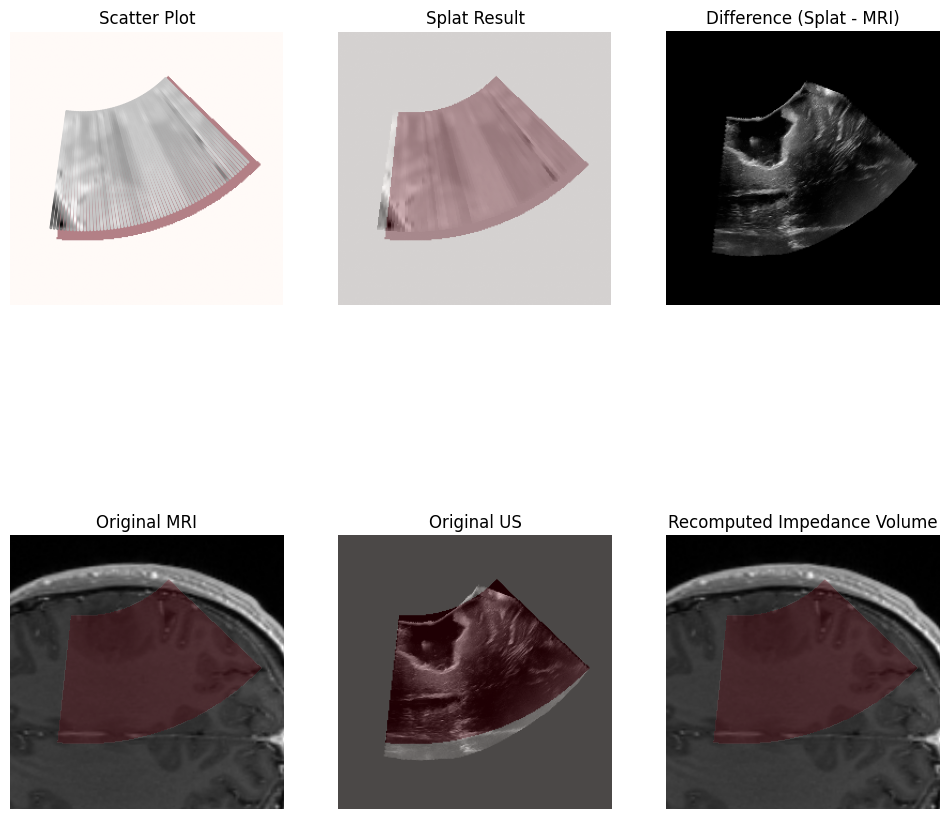

In [149]:
x,z, intensities = out_2
x = x.detach()
z = z.detach()
intensities = intensities.detach()
x_rot, z_rot = rotate_around_apex(x, 
                                  z, 
                                  apex=apex_mri_world[:2],
                                  median=[-0.3,-0.9])
final_image = differentiable_splat(torch.tensor(x_rot), 
                                   torch.tensor(z_rot), 
                                   torch.tensor(intensities), H=256, W=256, sigma=0.5)
# Compare scatter to splat
fig, ax = plt.subplots(2, 3, figsize=(12, 12))

# Scatter Plot
ax[0, 0].scatter(x_rot, z_rot, c=intensities, s=1, cmap='gray')
ax[0, 0].imshow(mask_segment_mri, alpha=0.5, origin='lower', cmap='Reds')
ax[0, 0].set_facecolor('black')
ax[0, 0].set_title("Scatter Plot")
ax[0, 0].set_xlim(0, 256)
ax[0, 0].set_ylim(0, 256)

# Splat Result
ax[0, 1].imshow(final_image, cmap='gray', origin='lower')
ax[0, 1].imshow(mask_segment_mri, alpha=0.3, origin='lower', cmap='Reds')
ax[0, 1].set_title("Splat Result")
ax[0, 1].set_xlim(0, 256)
ax[0, 1].set_ylim(0, 256)

# Original MRI
ax[1, 0].imshow(t1_slice, cmap='gray', origin='lower')
ax[1, 0].imshow(mask_segment_mri, cmap='Reds', alpha=0.3 * (mask_segment_mri > 0).astype(float), origin='lower')
ax[1, 0].set_title("Original MRI")

# Original US
ax[1, 1].imshow(us_slice, cmap='gray', origin='lower')
ax[1, 1].imshow(mask_segment_us, cmap='Reds', alpha=0.3, origin='lower')
ax[1, 1].set_title("Original US")

# Difference
ax[0, 2].imshow(-final_image + us_slice, cmap='gray', origin='lower')
ax[0, 2].set_title("Difference (Splat - MRI)")

# Recomputed Impedance_Vol
print("Recomputing Impedance Volume")
# Z_vol = model_one.forward(torch.tensor(T1_vol, dtype=torch.float32)).detach().numpy()
ax[1, 2].imshow(Z_vol[:, :, slice_idx], cmap='gray', origin='lower')
ax[1, 2].imshow(mask_segment_mri, cmap='Reds', alpha=0.3 * (mask_segment_mri > 0).astype(float), origin='lower')
ax[1, 2].set_title("Recomputed Impedance Volume")
for a in ax.flat:
    a.axis('off')
plt.show()


In [155]:
directions.shape

torch.Size([64, 3])

[INFO] Tracing rays with source: tensor([ 68.1002, 290.1414, 130.0000], dtype=torch.float64) and directions shape: torch.Size([64, 1, 3])
[INFO] Starting from sample index: 110 (for instance, to skip bones)
[INFO] Padded output to start from sample index: 110 torch.Size([64, 221])


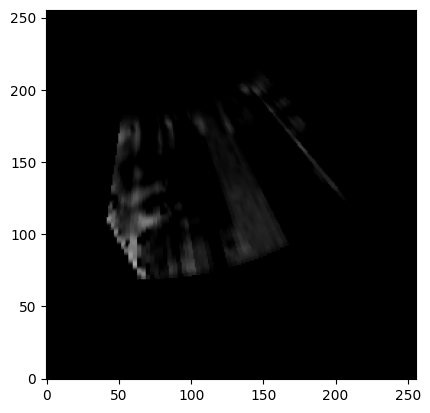

In [156]:
out_2 = renderer.plot_beam_frame(
    volume=torch.tensor(Z_vol),
    source=source,
    directions=directions,
    angle=np.degrees(opening_angle)/2,
    plot=False,
    artifacts=False,
    start=110
)
x,z = rotate_around_apex(out_2[0], 
                        out_2[1], 
                        apex=apex_mri_world[:2],
                        median=[-0.3,-0.9])
img = differentiable_splat(x, z, out_2[2], H=256, W=256, sigma=0.5)
plt.imshow(img, cmap='gray', vmin=0, vmax=intensities.max()*1.5, origin='lower')


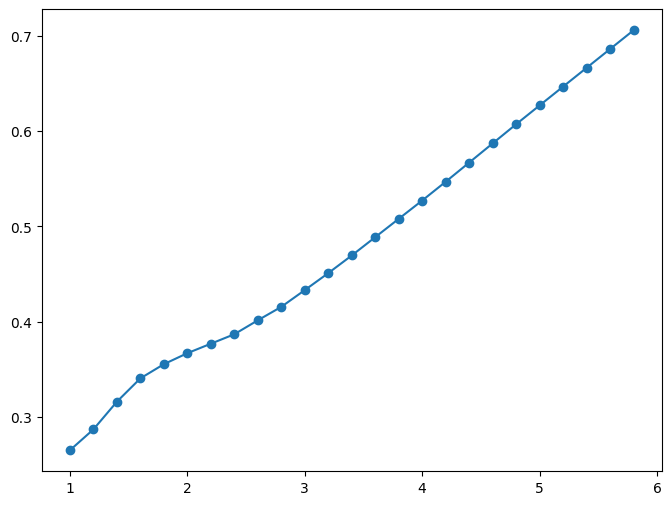

In [125]:
x = torch.arange(1, 6, step=0.2,dtype=torch.float32).reshape(-1, 1)
y = model_one.forward(x).detach()

plt.figure(figsize=(8, 6))
plt.plot(x.numpy(), y, marker='o', label='Predicted Impedance')